# Sentiment Analysis

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings


In [13]:
df = pd.read_csv('data/data.csv')

In [15]:
df.head()


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [16]:
df.describe()


,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


### removing missing data

In [17]:
df.isna().sum()


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [18]:
df.dropna(inplace = True)
df.isna().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

### Looking at target variable¶


In [19]:
df.status.value_counts()


status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

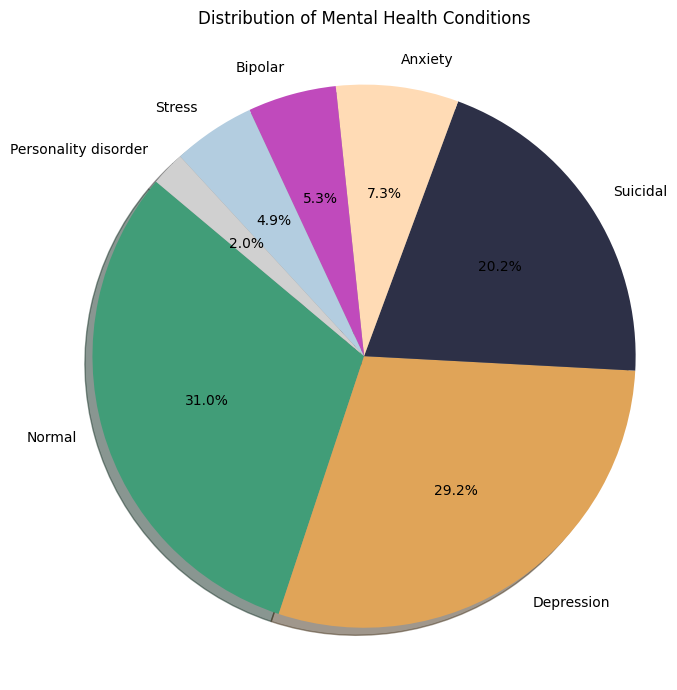

In [20]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

### The target variable in our dataset is unbalanced. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions.

In [21]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Scarlet Fever Hey guys, I’m a 20 year old male. I had a bit of a sore throat waking up on Sunday but nothing too serious thought not too much of it, as I was settling down for bed I noticed a bit of a rash on my chest which sent me to immediate panic. Fast forward to Monday and I have a full body rash and getting a lot of chills in the nights and when I wasn’t medicated in the day, I was pretty worried something was seriously wrong with me so organised an appointment with the doctor today. I went in and the doctor did a few tests on me (Checked my throat / tongue, Ears, chest, back and my blood pressure) and then told me “I’m sorry to tell you this but I’m afraid you have scarlet fever” I had no idea what it was until looking online after but surprised a 20 year old like myself has got it as it’s usually only children who get it to my understanding. I asked the doctor again and she confidently said that it was scarlet fever. I’m on a set of antibiotics for 10

In [34]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x )))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          563.967768          0.999905
std           826.776079          0.009742
min             0.000000          0.000000
25%            76.000000          1.000000
50%           308.000000          1.000000
75%           734.000000          1.000000
max         31499.000000          1.000000


### 3.1. Lowercasing¶


In [26]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,Unnamed: 0,original_statement,status,num_of_characters,statement
0,0,oh my gosh,Anxiety,10,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,"trouble sleeping, confused mind, restless hear..."
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,"all wrong, back off dear, forward doubt. stay ..."
3,3,I've shifted my focus to something else but I'...,Anxiety,61,i've shifted my focus to something else but i'...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,72,"i'm restless and restless, it's been a month n..."


### 3.2. Removing URLs, handles, punctuation and special characters¶


In [27]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,Unnamed: 0,original_statement,status,num_of_characters,statement
0,0,oh my gosh,Anxiety,10,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,trouble sleeping confused mind restless heart ...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,61,ive shifted my focus to something else but im ...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,72,im restless and restless its been a month now ...


### Tokenization

In [29]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,Unnamed: 0,original_statement,status,num_of_characters,statement,tokens
0,0,oh my gosh,Anxiety,10,oh my gosh,"[oh, my, gosh]"
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,3,I've shifted my focus to something else but I'...,Anxiety,61,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,4,"I'm restless and restless, it's been a month n...",Anxiety,72,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


### Stemming


In [31]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,Unnamed: 0,original_statement,status,num_of_characters,statement,tokens,tokens_stemmed
0,0,oh my gosh,Anxiety,10,oh my gosh,"[oh, my, gosh]",oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,61,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,72,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


### Stop Words

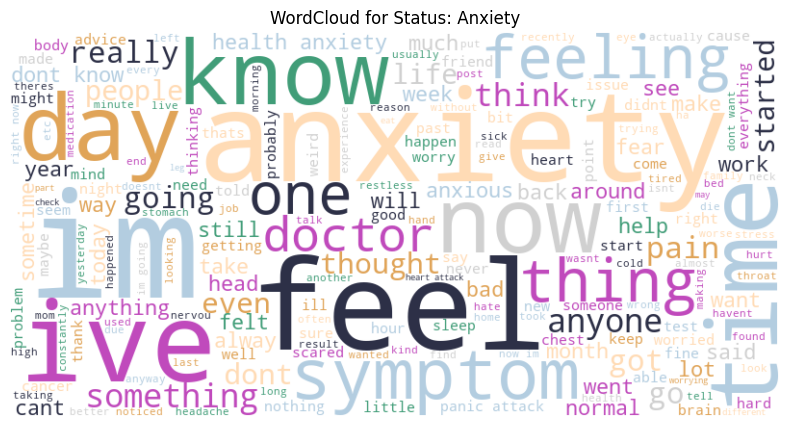

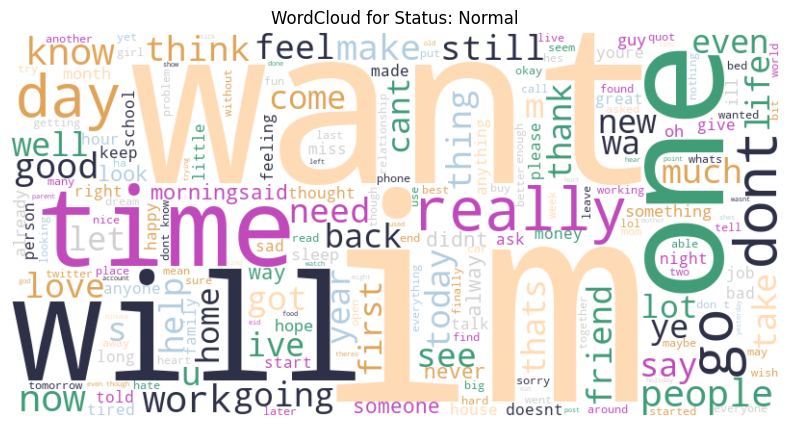

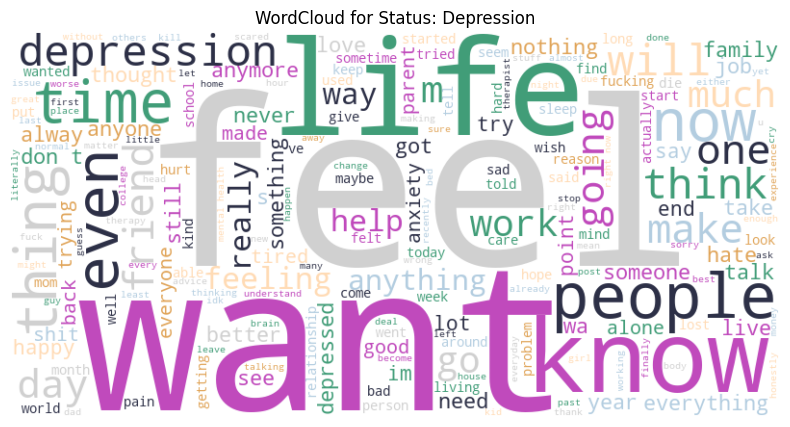

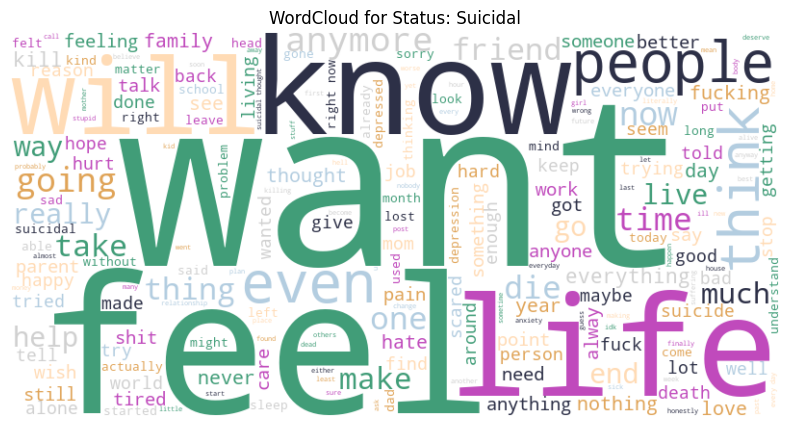

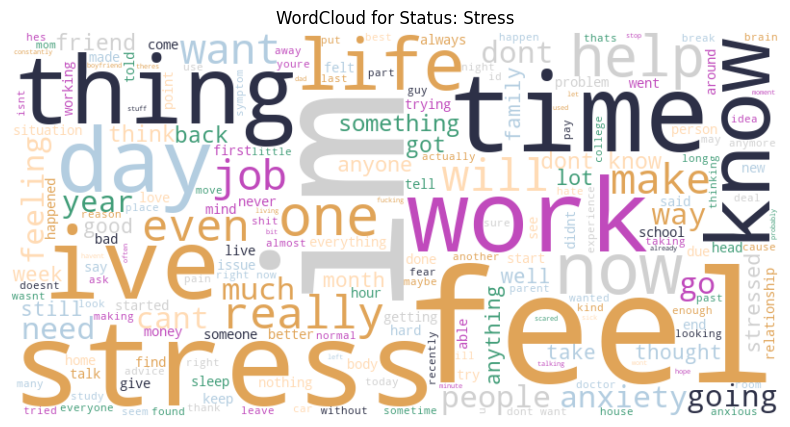

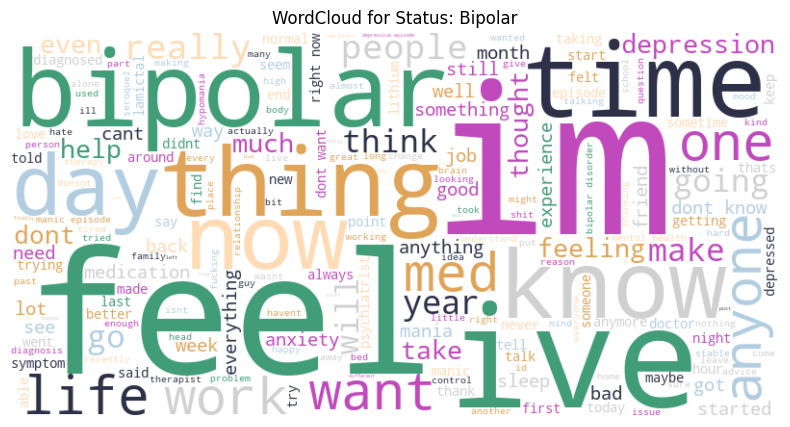

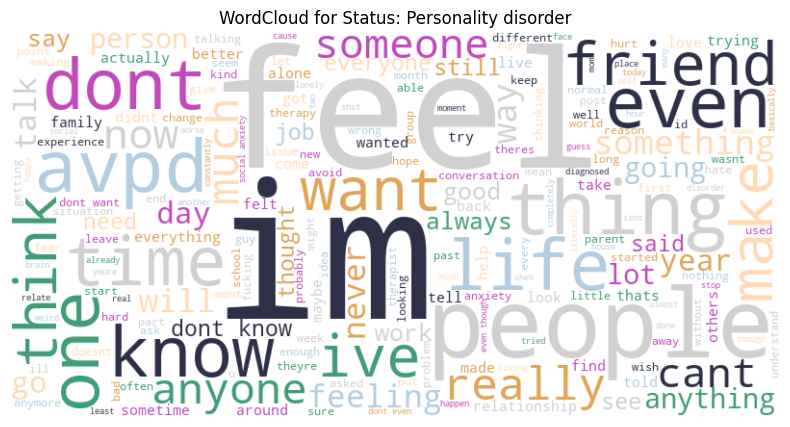

In [32]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

### Data Preprocessing

In [35]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

#### Label encoding target variable

In [36]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

#### Split the data into training and testing sets

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


#### Convert text to features using TF-IDF vectoriser

In [38]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [39]:
X_train_combined.shape


(42144, 50002)

### Resampling

In [40]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [41]:
X_train_resampled.shape


(91742, 50002)

### Model Traning and Evaluation

In [49]:
# Define a dictionary of classifiers with their specific parameters.
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='hist')
}



For Bernoulli Naive Bayes
Accuracy: 0.6409794059030084
                      precision    recall  f1-score   support

             Anxiety       0.66      0.60      0.63       768
             Bipolar       0.71      0.58      0.64       566
          Depression       0.66      0.48      0.56      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.86      0.36      0.51       202
              Stress       0.40      0.49      0.44       530
            Suicidal       0.60      0.54      0.57      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



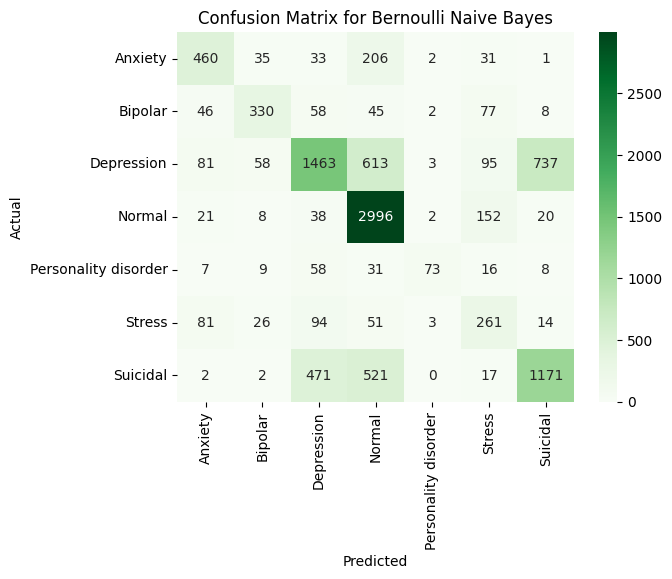



For Decision Tree
Accuracy: 0.6231375154218468
                      precision    recall  f1-score   support

             Anxiety       0.67      0.57      0.62       768
             Bipolar       0.82      0.45      0.58       566
          Depression       0.77      0.45      0.57      3050
              Normal       0.85      0.86      0.85      3237
Personality disorder       0.39      0.51      0.45       202
              Stress       0.18      0.72      0.29       530
            Suicidal       0.59      0.56      0.57      2184

            accuracy                           0.62     10537
           macro avg       0.61      0.59      0.56     10537
        weighted avg       0.71      0.62      0.64     10537



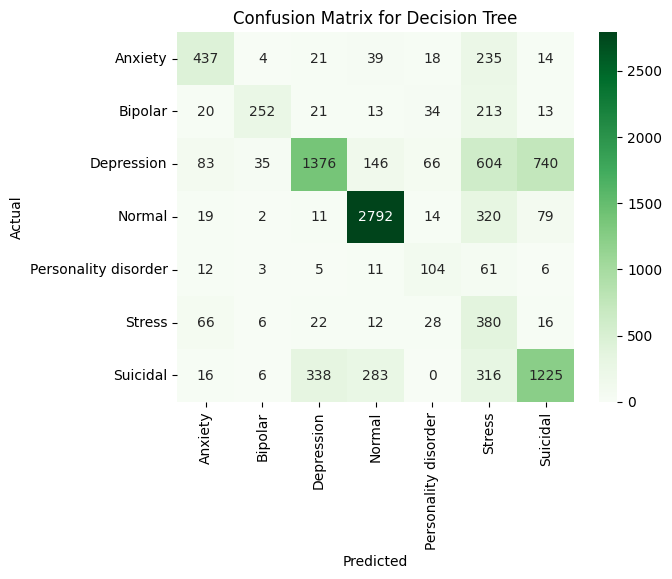



For Logistic Regression
Accuracy: 0.7640694694884692
                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       768
             Bipolar       0.82      0.80      0.81       566
          Depression       0.72      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.73      0.64      0.68       202
              Stress       0.59      0.65      0.62       530
            Suicidal       0.65      0.68      0.67      2184

            accuracy                           0.76     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.76      0.76     10537



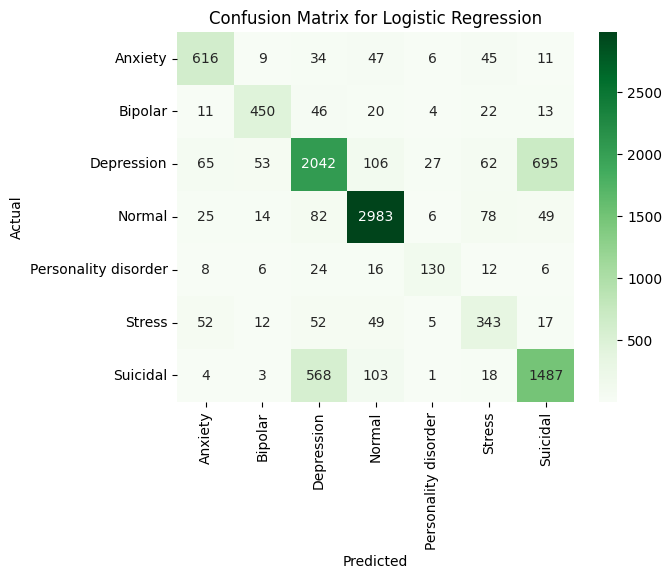



For XGB
Accuracy: 0.7990889247413875
                      precision    recall  f1-score   support

             Anxiety       0.81      0.85      0.83       768
             Bipolar       0.87      0.81      0.84       566
          Depression       0.77      0.72      0.74      3050
              Normal       0.92      0.93      0.93      3237
Personality disorder       0.87      0.64      0.74       202
              Stress       0.60      0.71      0.65       530
            Suicidal       0.69      0.73      0.71      2184

            accuracy                           0.80     10537
           macro avg       0.79      0.77      0.78     10537
        weighted avg       0.80      0.80      0.80     10537



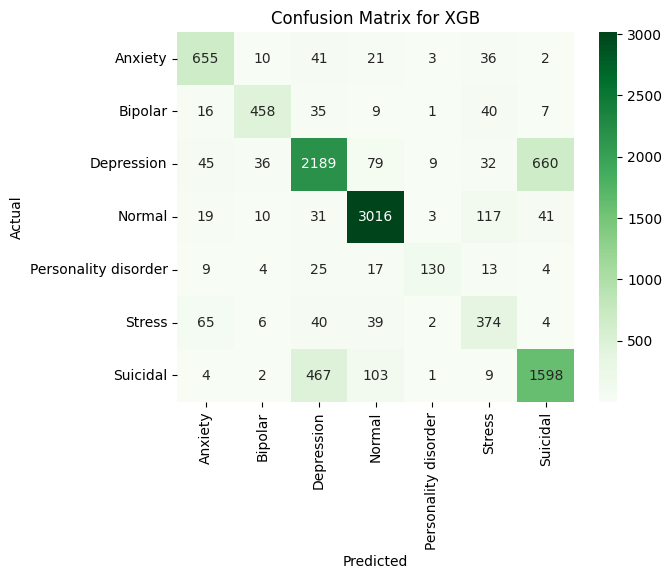

In [50]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

C:\Users\nicoa\AppData\Local\Temp\ipykernel_23476\2799218333.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)


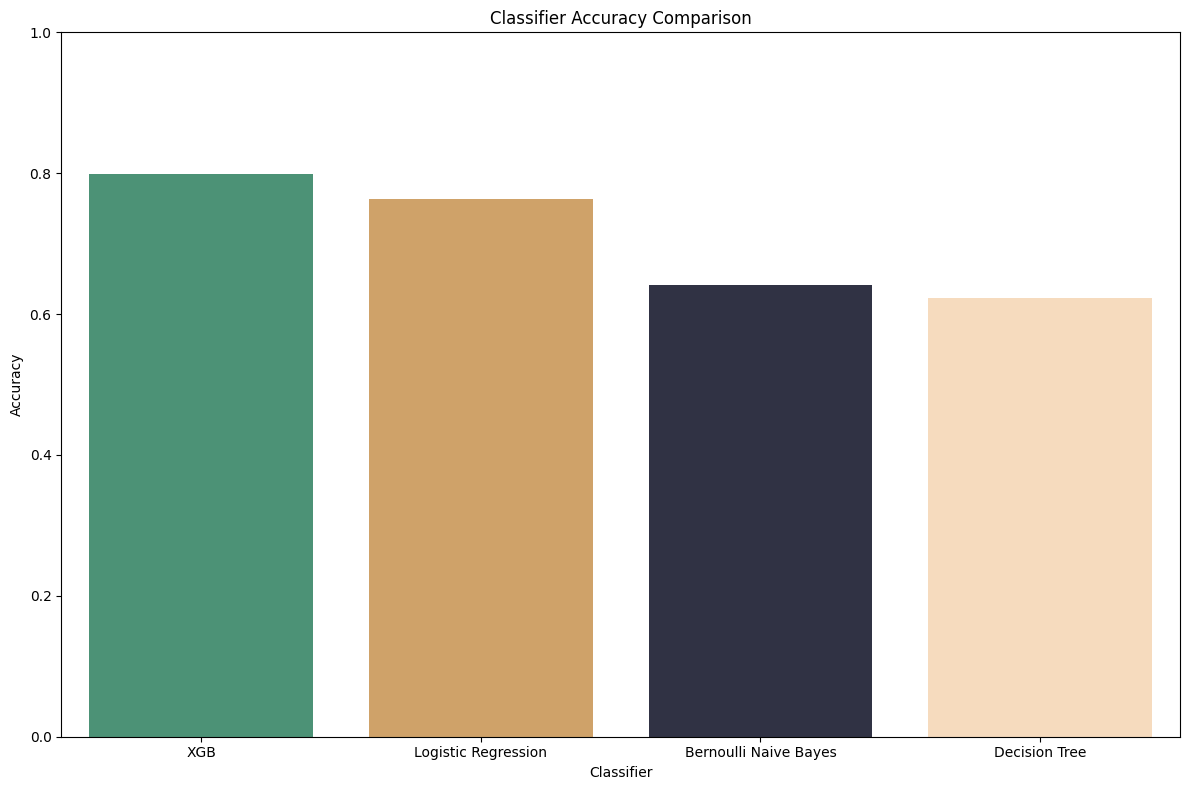

In [51]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
### XGBoost above all models acc 81% and R1 recall score for normal behavior higher which indicates that this was the easiest case to determine